# this notebook trains a savings model and compares scores the accuracy
- data is first loaded and merged
- then preprocessed
- split based on cic id into a train and test data set.
- Train a model to estimate hp_heat_produced and hp_elect_consumed per day
- The model is then used on the test data set to compare
    - savings by API
    - predicted avg. yearly savings (As-if-installed method)
    - predicted savings so far
    - actualised savings
- The comparison of those four metrics is used to see if this model outperforms the current model.

## initialize script

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import os
import seaborn as sns

import pickle

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor


## Load & merge data

In [119]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [120]:
# load expected savings data:
df_savings = pd.read_csv('./data/EnergyConsumption_test_data2.csv')
df_hubspot = pd.read_csv('./data/hubspot_data.csv')
df_cic_prod = pd.read_csv('./data/prod_cic.csv')

# merge df_savings with df_cic
df_hubspot['orderNr'] = df_hubspot['Deal Name'].str.extract(r'.*(QUATT\d+)')
df_savings = pd.merge(df_savings, df_cic_prod, left_on='orderNr', right_on='orderNumber', how='left')
df_savings = pd.merge(df_savings, df_hubspot, left_on='orderNr', right_on='orderNr', how='left')
df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')

# reformat date column
df_cic['date'] = pd.to_datetime(df_cic['date'], format='%Y-%m-%d')


In [121]:
# load temperature data from file
with open('./data/etmgeg_260.txt','r') as f:
    content = f.readlines()
    header = content[51].split(',')
    header = [h.strip() for h in header]
    data = [line.split(',') for line in content[53:-1]]

    df_knmi = pd.DataFrame(columns=header, data=data)

# add date columns to dataset
df_knmi['date'] = pd.to_datetime(df_knmi['YYYYMMDD'], format='%Y%m%d')
df_knmi['TG'] = df_knmi['TG'].astype(float)/10
df_knmi['year'] = df_knmi['date'].dt.year
df_knmi['month'] = df_knmi['date'].dt.month
df_knmi['day'] = df_knmi['date'].dt.day
df_knmi['month-day'] = df_knmi['date'].dt.strftime('%m-%d')

# rename relevant columns
df_knmi = df_knmi.rename(columns={'TG':'knmi_avg_temp',
                                  'TN':'knmi_min_temp',
                                  'TX':'knmi_max_temp',
                                  'SQ':'knmi_sunshine_duration',
                                  'SP':'knmi_sunshine_percentage',
                                  'Q':'knmi_global_radiation'})

In [122]:
df_cic = pd.merge(df_cic, 
                  df_knmi[['knmi_avg_temp',
                           'knmi_min_temp',
                           'knmi_max_temp',
                           'knmi_sunshine_duration',
                           'knmi_sunshine_percentage',
                           'knmi_global_radiation',
                           'date']],
                    on='date',
                    how='left')

## Clean data

In [123]:
# drop certain testing cic's
cic_blacklist = ['CIC-f42058e3-44c5-5d70-809d-f2ee78b2abf9',
                'CIC-46f31f71-9b6d-5af5-ba63-1c71d639dcc5',
                'CIC-691989e5-24b7-59b9-9807-537c89035f25',
                'CIC-33d8a5ac-84da-5531-9f93-dc3a3d2635bc',
                'CIC-b456cd2e-d054-5314-96e0-c06e38aac609',
                'CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977',
                'CIC-ab5dd581-df24-580e-b5c0-f80919325d5d']
df_cic.drop(df_cic[df_cic['cic_id'].isin(cic_blacklist)].index, inplace=True)

In [124]:
# drop rows that are compiled of inclomplete data (get rid of commissioning)
df_cic.drop(df_cic[df_cic['number_of_rows']<24].index, inplace=True)

## Feature engineering, imputation & further cleaning

In [125]:
# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_heat_generated'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_energy_consumed'] = df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1).astype(float)
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1)) # month weight factor as used in degree days method
df_cic['aardgas_verbruik_cat'] = df_cic['aardgas_verbruik'].apply(lambda x: 0 if x < 1000 else (1 if x < 2000 else (2 if x < 3000 else 3)))
df_cic['outside_temperature_avg'] = df_cic['outside_temperature_avg'].astype(float)

In [126]:
# calculate roomtemperature setpoint estimates
df_roomtemp_setpoints = (df_cic[(df_cic['heat_delivered']>1000)]
                         .groupby('cic_id')
                         .aggregate({'room_set_temperature_max': 'median',
                                    'room_set_temperature_avg': 'median',
                                    'room_set_temperature_min': 'median'})
)
# rename columns
df_roomtemp_setpoints.rename(columns={'room_set_temperature_max': 'room_set_temperature_max_median',
                                        'room_set_temperature_avg': 'room_set_temperature_avg_median',
                                        'room_set_temperature_min': 'room_set_temperature_min_median'}, inplace=True)

# merge setpoints onto df_cic
df_cic = pd.merge(df_cic, df_roomtemp_setpoints, left_on='cic_id', right_on='cic_id', how='left')

# drop rows with no room temperature setpoint
df_cic.drop(df_cic[df_cic['room_set_temperature_max_median'].isna()].index, inplace=True)

In [127]:
# filling Nan values
df_cic['numberOfHeatPumps'].fillna(1, inplace=True)
df_cic['Zone regeling'].fillna('Nee', inplace=True)

# preprocess hubspot data
# merge 'Weet niet' and 'Weet ik niet' and 'nan' values to -> unkown
replacement_dict = {None: 'unknown', 
                    'Weet niet': 'unknown',
                    'Weet ik niet': 'unknown'}
df_cic.replace({'Spouwmuurisolatie': replacement_dict,
                    'Muurisolatie aan de binnen- of buitenkant': replacement_dict,
                    'Dakisolatie': replacement_dict,
                    'Vloerisolatie': replacement_dict,
                    'Dubbel glas': replacement_dict,
                    'HR++ glas': replacement_dict,
                    }, inplace=True)

# rename long column
df_cic.rename(columns={'Muurisolatie aan de binnen- of buitenkant': 'Muurisolatie'}, inplace=True)

# isolation parameters to ordinal encoding
ordinal_mapping = {
    'unknown': 0,
    'Nee': 1, 
    'Ja (meer dan 10 jaar geleden geplaatst)': 2, 
    'Ja (minder dan 10 jaar geleden geplaatst)': 3
}

ordinal_columns = ['Spouwmuurisolatie', 'Muurisolatie', 'Dakisolatie', 'Vloerisolatie', 'Dubbel glas', 'HR++ glas']

for column in ordinal_columns:
    df_cic[column] = df_cic[column].fillna('unknown').map(ordinal_mapping)



# add ordinal encoding for categorical variables
df_cic['woning_type_ordinal'] = df_cic['woning_type'].map({'Vrijstaande woning': 0,
                                         '2-onder-1-kap': 1,
                                         'Hoekwoning': 2,
                                         'Tussenwoning': 3,
                                         'Appartement': 4})

df_cic['Zone_regeling_ordinal'] = df_cic['Zone regeling'].map({'Nee': 0,
                                             'Ja': 1,
                                             None: 0})

df_cic['bouwjaar'] = df_cic['bouwjaar'].map({'Voor 1970': 'Voor 1970',
                                            'voor 1970': 'Voor 1970',
                                            'Tussen 1970 en 1990': 'Tussen 1970 en 1990',
                                            '1970-1990': 'Tussen 1970 en 1990',
                                            '1974': 'Tussen 1970 en 1990',
                                            '1980': 'Tussen 1970 en 1990',
                                            'Tussen 1990 en 2000': 'Tussen 1990 en 2000',
                                            'Tussen 1995': 'Tussen 1990 en 2000',
                                            'Na 2000': 'Na 2000',
                                            '2000': 'Na 2000',
                                            '2005': 'Na 2000',
                                            '2010': 'Na 2000'})
df_cic['bouwjaar_ordinal'] = df_cic['bouwjaar'].map({'Voor 1970': 0,
                                   'Tussen 1970 en 1990': 1,
                                   'Tussen 1990 en 2000': 2,
                                   'Na 2000': 3})


## feature selection

In [128]:
df_cic_subset = (
    df_cic[
        (df_cic['outside_temperature_avg']<16) &
        (df_cic['outside_temperature_avg'].notna()) &
        (df_cic['Elektriciteit'].notna())]
                                  # feature list
                                  [[
                                      # id to split
                                        'cic_id',
                                      # features from cic measurements
                                      # 'outside_temperature_avg',
                                      # 'outside_temperature_min',
                                      # 'outside_temperature_max',
                                      # 'room_set_temperature_max_median',
                                      # 'room_set_temperature_avg_median',
                                      # 'room_set_temperature_min_median',
                                      # 'room_temperature_max',
                                      # 'room_temperature_avg',
                                      # 'room_temperature_min',
                                      'month',
                                      # features from cic data
                                      'numberOfHeatPumps',
                                      # features from savings calc.
                                      'referentie_warmtevraag_per_m2',
                                      # 'geschiktheid_woning',  # remove
                                      'aardgas_verbruik',
                                      'bouwjaar_ordinal',
                                      'woning_type_ordinal',
                                      'oppervlakte',
                                      'afgiftesysteem',
                                      'geschiktheidscategorie',  # remove
                                      'referentie_warmtevraag',
                                      'stookgrens',  # remove
                                      # features from hubspot
                                      'Spouwmuurisolatie',
                                      'Muurisolatie',
                                      'Dakisolatie',
                                      'Vloerisolatie',
                                      'Dubbel glas',
                                      'HR++ glas',
                                      'Zone_regeling_ordinal',
                                      'Woning comfort',
                                      'Elektriciteit',
                                      # features from knmi
                                      'knmi_avg_temp',
                                      'knmi_min_temp',
                                      'knmi_max_temp',
                                      'knmi_sunshine_duration',
                                      'knmi_sunshine_percentage',
                                      'knmi_global_radiation',
                                      # target variables
                                      'hp_heat_generated',
                                      'hp_energy_consumed'
                                      ]]
)

# One hot encoding for categorical variables with multiple values
df_cic_subset = pd.merge(df_cic_subset, df_cic_subset['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
df_cic_subset = pd.merge(df_cic_subset, df_cic_subset['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
# drop afgiftesysteem and Woning comfort
df_cic_subset.drop(['afgiftesysteem', 'Woning comfort'], axis=1, inplace=True)

df_cic_subset = df_cic_subset.dropna(axis=0)
# split df_total back into X and y
X = df_cic_subset.drop(['hp_heat_generated','hp_energy_consumed'], axis=1)
y = df_cic_subset[['hp_heat_generated', 'hp_energy_consumed']]

## train test split based on cic_id

In [129]:
# # split into train and test set based on cic_id
# gss = GroupShuffleSplit(n_splits=1, test_size=20, random_state=42)
# train_ix, test_ix = next(gss.split(X, y, groups=X.cic_id))

In [130]:
# Pre-select cic_id values based on first data point
condition = (X.groupby('cic_id').month.count() > 120)
selected_cic_ids = condition[condition].index.tolist()
selected_test_cic_ids = np.random.choice(selected_cic_ids, size=20, replace=False)

# Use these cic_id values to create the test set
test_mask = X['cic_id'].isin(selected_test_cic_ids)
test_ix = np.where(test_mask)[0]

# Create the train set using the remaining data
train_mask = ~test_mask
train_ix = np.where(train_mask)[0]

# create train and test data set
X_train = X.drop(['cic_id'], axis=1).iloc[train_ix]
X_test = X.drop(['cic_id'], axis=1).iloc[test_ix]

#
y_heat = y['hp_heat_generated']
y_heat_train = y_heat.iloc[train_ix]
y_heat_test = y_heat.iloc[test_ix]

y_energy = y['hp_energy_consumed']
y_energy_train = y_energy.iloc[train_ix]
y_energy_test = y_energy.iloc[test_ix]

## train random forest models

In [131]:
X_train.columns.values

array(['month', 'numberOfHeatPumps', 'referentie_warmtevraag_per_m2',
       'aardgas_verbruik', 'bouwjaar_ordinal', 'woning_type_ordinal',
       'oppervlakte', 'geschiktheidscategorie', 'referentie_warmtevraag',
       'stookgrens', 'Spouwmuurisolatie', 'Muurisolatie', 'Dakisolatie',
       'Vloerisolatie', 'Dubbel glas', 'HR++ glas',
       'Zone_regeling_ordinal', 'Elektriciteit', 'knmi_avg_temp',
       'knmi_min_temp', 'knmi_max_temp', 'knmi_sunshine_duration',
       'knmi_sunshine_percentage', 'knmi_global_radiation', 'Anders',
       'Convectoren aan de wand', 'Convectoren in de vloer', 'Radiatoren',
       'Vloerverwarming', 'Goed', 'Soms te koud', 'Soms te warm',
       'Vaak te koud', 'Vaak te warm'], dtype=object)

In [132]:
regr_heat = RandomForestRegressor(n_estimators=10,
                                    max_depth=18, 
                                    random_state=0,
                                    criterion='absolute_error')
regr_heat.fit(X_train, y_heat_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=18, n_estimators=10,
                      random_state=0)

In [133]:
regr_elec = RandomForestRegressor(n_estimators=10,
                                    max_depth=18, 
                                    random_state=0,
                                    criterion='absolute_error')
regr_elec.fit(X_train, y_energy_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=18, n_estimators=10,
                      random_state=0)

## Evaluation:
- get value of savings calculation per cic
- calculate as if savings for last 10 years

## get 10 year avg. savings prediction

In [168]:
df_test = X.iloc[test_ix]
test_cics = df_test.groupby('cic_id').aggregate('first').drop(['month',
                                                               'knmi_avg_temp',
                                                               'knmi_min_temp',
                                                               'knmi_max_temp',
                                                               'knmi_sunshine_duration',
                                                               'knmi_sunshine_percentage',
                                                               'knmi_global_radiation'], axis=1)
# make from index 'cic_id' column
test_cics.reset_index(inplace=True)


df_knmi_10_yr = df_knmi[(df_knmi['year']>=2013) & (df_knmi['year']<=2022)][[
    'knmi_avg_temp',
    'knmi_min_temp',
    'knmi_max_temp',
    'knmi_sunshine_duration',
    'knmi_sunshine_percentage',
    'knmi_global_radiation',
    'month',
    'year'
]]

X_test_10yr = df_knmi_10_yr.merge(test_cics, how='cross')

In [180]:
# predict heat & electricity per day
X_test_10yr['y_heat_pred'] = regr_heat.predict(X_test_10yr[X_train.columns])
X_test_10yr['y_elec_pred'] = regr_elec.predict(X_test_10yr[X_train.columns])

X_test_10yr['savings'] = X_test_10yr.apply(lambda x: calculate_savings(x['y_heat_pred'], 
                                                                        x['y_elec_pred']), 
                                                                        axis=1)



In [201]:
df_savings[['besparing','netto_kosten','terugverdientijd_jaren', 
            'extra_verbruik_tbv_WP','gas_besparing']]

,besparing,netto_kosten,terugverdientijd_jaren,extra_verbruik_tbv_WP,gas_besparing
0,192.67,2149.0,11.15,415.20,191.25
1,559.56,2499.0,4.47,2088.69,962.09
2,791.06,2149.0,2.72,1704.76,785.24
3,921.33,2149.0,2.33,1985.48,914.55
4,635.29,2149.0,3.38,1708.72,909.50
...,...,...,...,...,...
2911,1243.30,2149.0,1.73,1974.91,1051.19
2912,541.00,2149.0,3.97,1564.46,640.55
2913,1737.72,1599.0,0.92,2238.68,1031.18
2914,1343.38,2949.0,2.20,4104.85,2058.84


In [195]:
cic_10_year

,y_heat_pred,y_elec_pred,savings,year,cic_id,id_y,besparing
0,8.014424e+06,2.732262e+06,227.653589,2013,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,810.84
1,6.686773e+06,1.957908e+06,318.634854,2014,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,810.84
2,6.917628e+06,2.126044e+06,289.418726,2015,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,810.84
3,7.993240e+06,2.515858e+06,310.724791,2016,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,810.84
4,7.189689e+06,2.228346e+06,293.326270,2017,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,810.84
...,...,...,...,...,...,...,...
195,5.532804e+06,1.807108e+06,188.811847,2018,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,928.22
196,5.371218e+06,1.559597e+06,261.191426,2019,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,928.22
197,5.127606e+06,1.456985e+06,262.095539,2020,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,928.22
198,5.764303e+06,1.777506e+06,238.797610,2021,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,CIC-fc1e25fb-a977-59bb-995f-cc369cf21ddf,928.22


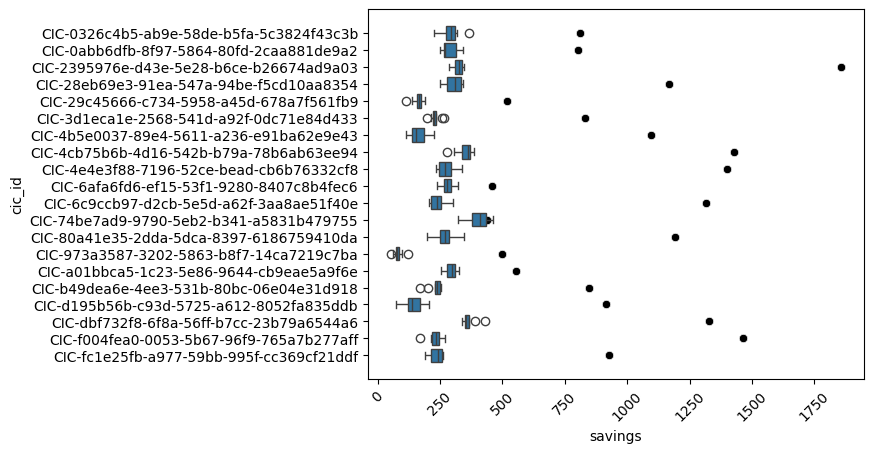

In [202]:
cic_10_year = X_test_10yr[['year',
            'cic_id',
            'y_heat_pred',
            'y_elec_pred',
            'savings']].groupby(['cic_id', 'year']).aggregate({'y_heat_pred': 'sum',
                                                                'y_elec_pred': 'sum',
                                                                'savings': 'sum',
                                                                'year': 'first',
                                                                'cic_id': 'first'})

cic_10_year['y_elec_pred'] = cic_10_year['y_elec_pred'] /1000
cic_10_year['gas_saved'] = cic_10_year['y_heat_pred'] / 8800

# old_savings estimation
cic_10_year.reset_index(drop = True, inplace = True)
cic_10_year = pd.merge(cic_10_year, df_savings[['id_y','besparing', 'extra_verbruik_tbv_WP', 'gas_besparing']], left_on='cic_id', right_on='id_y', how='left')


# boxplot savings per year per cic
sns.boxplot(y='cic_id', x='savings', data=cic_10_year)
# plot besparing values on top of boxplot
sns.scatterplot(y='cic_id', x='besparing', data=cic_10_year, color='black')
plt.xticks(rotation=45)
plt.show()

In [212]:
# average savings per cic 
avg_per_cic_10yr = cic_10_year.groupby('cic_id').aggregate({'savings': 'mean',
                                        'besparing': 'mean',
                                        'extra_verbruik_tbv_WP': 'mean',
                                        'gas_besparing': 'mean'})
# change index to column cic_id
avg_per_cic_10yr.reset_index(inplace=True)


,cic_id,savings,besparing,extra_verbruik_tbv_WP,gas_besparing
0,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,294.319177,810.84,2242.15,918.02
1,CIC-0abb6dfb-8f97-5864-80fd-2caa881de9a2,288.468447,804.53,2163.91,1151.79
2,CIC-2395976e-d43e-5e28-b6ce-b26674ad9a03,323.362027,1858.52,1839.16,978.93
3,CIC-28eb69e3-91ea-547a-94be-f5cd10aa8354,305.464463,1167.33,1503.85,692.70
4,CIC-29c45666-c734-5958-a45d-678a7f561fb9,163.012441,518.40,851.41,348.60
5,CIC-3d1eca1e-2568-541d-a92f-0dc71e84d433,229.661606,830.18,1773.56,816.94
6,CIC-4b5e0037-89e4-5611-a236-e91ba62e9e43,162.923873,1094.69,1410.27,649.60
7,CIC-4cb75b6b-4d16-542b-b79a-78b6ab63ee94,350.603605,1427.27,2344.14,959.78
8,CIC-4e4e3f88-7196-52ce-bead-cb6b76332cf8,274.620610,1398.05,1801.08,829.61
9,CIC-6afa6fd6-ef15-53f1-9280-8407c8b4fec6,279.215304,460.20,949.77,388.87


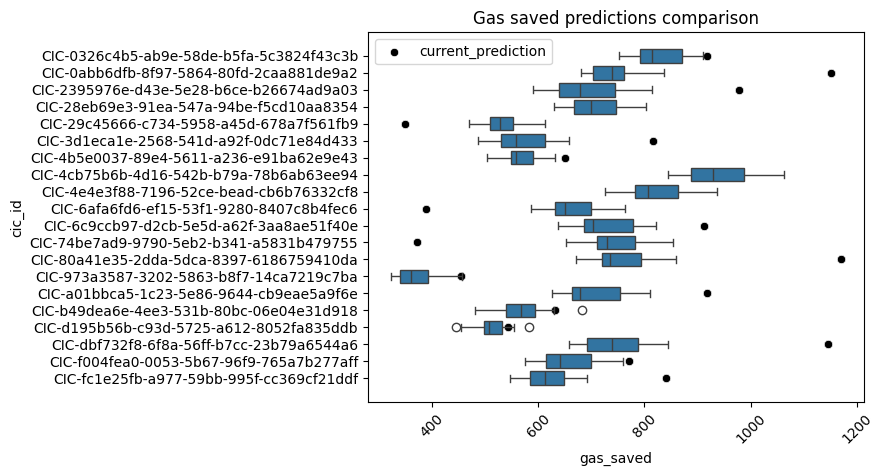

In [205]:
# boxplot savings per year per cic
sns.boxplot(y='cic_id', x='gas_saved', data=cic_10_year)
# plot besparing values on top of boxplot
sns.scatterplot(y='cic_id', x='gas_besparing', data=cic_10_year, color='black', label='current_prediction')
plt.xticks(rotation=45)
plt.legend()
plt.title('Gas saved predictions comparison')
plt.show()

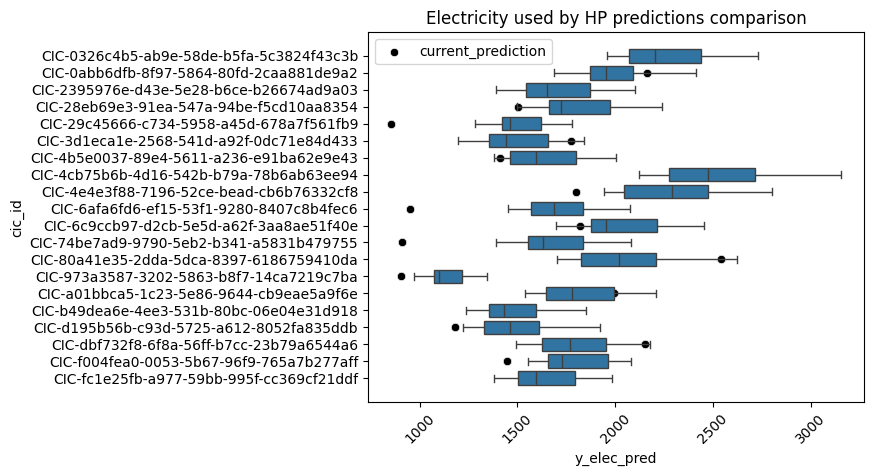

In [206]:
# boxplot savings per year per cic
sns.boxplot(y='cic_id', x='y_elec_pred', data=cic_10_year)
# plot besparing values on top of boxplot
sns.scatterplot(y='cic_id', x='extra_verbruik_tbv_WP', data=cic_10_year, color='black', label='current_prediction')
plt.xticks(rotation=45)
plt.legend()
plt.title('Electricity used by HP predictions comparison')
plt.show()

In [ ]:
# test data set
df_test = X.iloc[test_ix]
df_test['hp_heat_generated'] = y_heat_test
df_test['hp_energy_consumed'] = y_energy_test


In [ ]:
ELECTRICITY_PRICE = 0.4
GAS_PRICE = 1.45
HEAT_PER_M3_GAS = 8800

def calculate_savings(heat_generated, electricity_consumed):
    m3_gas_saved = heat_generated / HEAT_PER_M3_GAS
    gas_costs_saved = m3_gas_saved * GAS_PRICE
    elec_costs = electricity_consumed * ELECTRICITY_PRICE
    return gas_costs_saved - elec_costs

df_per_cic = df_test[['cic_id',
                        'hp_heat_generated',
                        'hp_energy_consumed',
                        'date']].groupby('cic_id').aggregate(
                            {'hp_heat_generated': 'sum',
                            'hp_energy_consumed': 'sum',
                            'date': 'min',
                            'date': 'max',
                            'cic_id': 'first',
                            'cic_id': 'count'})
df_per_cic['savings'] = df_per_cic.apply(lambda x: calculate_savings(x['hp_heat_generated'], 
                                                                        x['hp_energy_consumed']), 
                                                                        axis=1)


In [ ]:
df_per_cic

In [ ]:
df_per_cic.rename(columns={'hp_heat_generated': 'hp_heat_generated_sum',
                            'hp_energy_consumed': 'hp_energy_consumed_sum',
                            'date': 'date_max',
                            'cic_id': 'cic_id_count'}, inplace=True)

In [136]:
heat_pred = regr_heat.predict(X_test)
elec_pred = regr_elec.predict(X_test)


In [145]:
ELECTRICITY_PRICE = 0.4
GAS_PRICE = 1.45
HEAT_PER_M3_GAS = 8800

def calculate_savings(heat_generated, electricity_consumed):
    m3_gas_saved = heat_generated / HEAT_PER_M3_GAS
    gas_costs_saved = m3_gas_saved * GAS_PRICE
    elec_costs = electricity_consumed/1000 * ELECTRICITY_PRICE
    return gas_costs_saved - elec_costs

In [210]:
df_test = X.iloc[test_ix]
df_test['hp_heat_generated'] = y_heat_test
df_test['hp_energy_consumed'] = y_energy_test
df_test['hp_heat_generated_pred'] = heat_pred
df_test['hp_energy_consumed_pred'] = elec_pred
df_test['savings'] = df_test.apply(lambda x: calculate_savings(x['hp_heat_generated'],
                                                                x['hp_energy_consumed']),
                                                                axis=1)
df_test['savings_pred'] = df_test.apply(lambda x: calculate_savings(x['hp_heat_generated_pred'],
                                                                x['hp_energy_consumed_pred']),
                                                                axis=1)

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_84169/501002865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['hp_heat_generated'] = y_heat_test
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_84169/501002865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['hp_energy_consumed'] = y_energy_test
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_84169/501002865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [217]:
df_per_cic = df_test.groupby('cic_id').aggregate(
                            {'hp_heat_generated': 'sum',
                            'hp_energy_consumed': 'sum',
                            'hp_heat_generated_pred': 'sum',
                            'hp_energy_consumed_pred': 'sum',
                            'savings': 'sum',
                            'savings_pred': 'sum'})
df_per_cic.reset_index(inplace=True)
df_per_cic = pd.merge(df_per_cic, avg_per_cic_10yr, left_on='cic_id', right_on='cic_id', how='left')

In [220]:
df_per_cic

,cic_id,hp_heat_generated,hp_energy_consumed,hp_heat_generated_pred,hp_energy_consumed_pred,savings_x,savings_pred,savings_y,besparing,extra_verbruik_tbv_WP,gas_besparing,besparing_scaled
0,CIC-0326c4b5-ab9e-58de-b5fa-5c3824f43c3b,1.170725e+06,4.505435e+05,4.488298e+06,1.375181e+06,12.686245,189.476593,294.319177,810.84,2242.15,918.02,34.950204
1,CIC-0abb6dfb-8f97-5864-80fd-2caa881de9a2,5.357656e+06,1.319989e+06,4.631004e+06,1.353890e+06,354.800087,221.507112,288.468447,804.53,2163.91,1151.79,989.526991
2,CIC-2395976e-d43e-5e28-b6ce-b26674ad9a03,4.920232e+06,1.520342e+06,3.271274e+06,9.578850e+05,202.583227,155.862670,323.362027,1858.52,1839.16,978.93,1164.345057
3,CIC-28eb69e3-91ea-547a-94be-f5cd10aa8354,3.387905e+06,1.087268e+06,2.807197e+06,8.667364e+05,123.327067,115.854957,305.464463,1167.33,1503.85,692.70,471.293400
4,CIC-29c45666-c734-5958-a45d-678a7f561fb9,6.092195e+04,6.629179e+04,2.527956e+06,8.292684e+05,-16.478440,84.830857,163.012441,518.40,851.41,348.60,-52.403506
5,CIC-3d1eca1e-2568-541d-a92f-0dc71e84d433,3.120076e+06,8.877026e+05,3.250133e+06,9.160020e+05,159.022337,169.132488,229.661606,830.18,1773.56,816.94,574.833409
6,CIC-4b5e0037-89e4-5611-a236-e91ba62e9e43,4.098906e+06,1.263309e+06,2.942107e+06,9.264536e+05,170.064435,114.197570,162.923873,1094.69,1410.27,649.60,1142.667636
7,CIC-4cb75b6b-4d16-542b-b79a-78b6ab63ee94,3.003488e+06,9.734282e+05,3.380522e+06,1.010751e+06,105.521689,152.717243,350.603605,1427.27,2344.14,959.78,429.567577
8,CIC-4e4e3f88-7196-52ce-bead-cb6b76332cf8,4.092964e+06,1.182822e+06,3.635929e+06,1.184541e+06,201.279937,125.285673,274.620610,1398.05,1801.08,829.61,1024.684256
9,CIC-6afa6fd6-ef15-53f1-9280-8407c8b4fec6,4.279681e+06,1.085510e+06,2.245109e+06,6.523542e+05,270.970943,108.990963,279.215304,460.20,949.77,388.87,446.611724


In [227]:
df_per_cic['besparing_scaled'] = df_per_cic['savings_pred'] / df_per_cic['savings_y'] * df_per_cic['besparing']

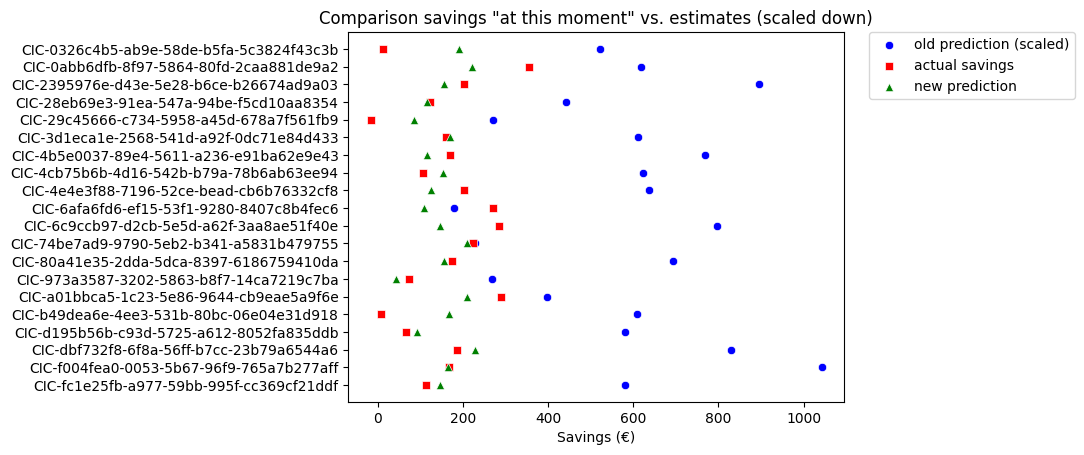

In [229]:
# plot per cic : besparing_scaled: old prediction scaled, savings_x: actual savings, en savings_pred: new prediction
sns.scatterplot(data=df_per_cic, x='besparing_scaled', y='cic_id', label='old prediction (scaled)', marker='o', color='blue')
sns.scatterplot(data=df_per_cic, x='savings_x', y='cic_id', label='actual savings', marker='s', color='red')
sns.scatterplot(data=df_per_cic, x='savings_pred', y='cic_id', label='new prediction', marker='^', color='green')
# place legend outside of graph
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison savings "at this moment" vs. estimates (scaled down)')
plt.xlabel('Savings (€)')
plt.ylabel('')
plt.show()

In [151]:
df_knmi_10_yr = df_knmi[(df_knmi['year']>=2013) & (df_knmi['year']<=2022)][[
    'knmi_avg_temp',
    'knmi_min_temp',
    'knmi_max_temp',
    'knmi_sunshine_duration',
    'knmi_sunshine_percentage',
    'knmi_global_radiation',
    'month'
]]


,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,UX,UXH,UN,UNH,EV24,date,year,month,day,month-day
40908,260,20130101,250,37,42,80,1,10,9,140,...,97,7,75,14,2\n,2013-01-01,2013,1,1,01-01
40909,260,20130102,239,37,39,60,21,20,7,110,...,98,23,77,13,4\n,2013-01-02,2013,1,2,01-02
40910,260,20130103,255,38,39,60,1,30,5,120,...,98,1,86,15,2\n,2013-01-03,2013,1,3,01-03
40911,260,20130104,272,37,38,50,13,30,6,100,...,98,3,90,12,1\n,2013-01-04,2013,1,4,01-04
40912,260,20130105,267,23,24,30,1,20,3,60,...,98,22,90,5,1\n,2013-01-05,2013,1,5,01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44555,260,20221227,206,45,47,60,20,30,6,110,...,89,6,78,21,3\n,2022-12-27,2022,12,27,12-27
44556,260,20221228,204,70,71,80,8,60,1,160,...,93,19,81,24,1\n,2022-12-28,2022,12,28,12-28
44557,260,20221229,221,68,69,80,3,50,24,170,...,88,2,75,7,2\n,2022-12-29,2022,12,29,12-29
44558,260,20221230,195,55,62,90,18,40,3,170,...,95,24,78,12,1\n,2022-12-30,2022,12,30,12-30


In [ ]:
def calculate_savings(heat_generated, electricity_consumed):
    m3_gas_saved = heat_generated / HEAT_PER_M3_GAS
    gas_costs_saved = m3_gas_saved * GAS_PRICE
    elec_costs = electricity_consumed * ELECTRICITY_PRICE
    return gas_costs_saved - elec_costs

def get_actualised_savings(df_test):
    df_per_cic = df_test[['cic_id',
                           'hp_heat_generated',
                           'hp_energy_consumed',
                           'date']].groupby('cic_id').aggregate(
                                {'hp_heat_generated': 'sum',
                                'hp_energy_consumed': 'sum',
                                'date': 'min',
                                'date': 'max',
                                'cic_id': 'first',
                                'cic_id': 'count'})
    df_per_cic['savings'] = df_per_cic.apply(lambda x: calculate_savings(x['hp_heat_generated'], 
                                                                         x['hp_energy_consumed']), 
                                                                         axis=1)

    return df_per_cic

In [ ]:
def predict_savings_per_day(regr_heat, regr_elec, weather, installation_features):
    